In [357]:
%matplotlib inline
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from imageio import imwrite
from random import sample
from collections import namedtuple
from functools import partial
plt.rcParams['image.cmap'] = 'gray' # plot as gray scale
s = plt.imshow #show

In [2]:
Point = namedtuple('Point', ['x', 'y'])
Box = namedtuple('Box', ['p1', 'p2'])

In [3]:
PATH = '/mnt/maxiv/common/ML-crystals/lyzo1_frames/'

In [33]:
### Reading images
def read_image(name, flag=cv2.IMREAD_COLOR):
    return cv2.imread(name, flag)


def crop(img):
    max_idx = np.argmax(img.shape)
    diff = np.abs(np.diff(img.shape))[0]
    cut1 = diff // 2
    cut2 = diff - cut1
    return img[:, cut1:-cut2] if max_idx == 1 else img[cut1:-cut2, :]


def resize(img, sz):
    shape = np.array(img.shape)
    if np.all(shape[:2] == sz):
        return img
    if np.any(shape[:2] != len(img)):
        img = crop(img)
    return cv2.resize(img, (sz, sz))


def to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def read_sample_images(n=10, flag=cv2.IMREAD_COLOR, scale: int = None):
    fls = os.listdir(PATH)
    fls = [PATH + f for f in fls]
    fls = sample(fls, n)
    imgs = [read_image(f, flag) for f in fls]
    if scale is None:
        return imgs, fls
    imgs = [resize(img, scale) for img in imgs]
    return imgs, fls

In [5]:
### Plotting
def plot_images(images, titles=None, scatters=None):
    COLS = 2
    fig = plt.figure(figsize=(15, 40))
    for i, img in enumerate(images):
        ax = fig.add_subplot((len(images) // COLS) + 1, COLS, i + 1)
        if scatters is not None:
            ax.scatter(
                scatters[i][0], scatters[i][1], s=50, c='red', marker='o')
        if titles is not None:
            ax.set_title(titles[i])
        ax.imshow(img)


def plot_histo(img, bins):
    hist, bins = np.histogram(img.ravel(), bins=bins, range=(0, 256))
    plt.hist(img.ravel(), bins=bins, range=(0, 256))

In [428]:
### Utils
def draw_rectangle(img, box: Box, color=(255, 0, 0), width=None):
    if width is None:
        width = int(np.ceil(len(img) * 0.005))
    p1, p2 = box
    copy = img.copy()
    cv2.rectangle(copy, p1, p2, color, width)
    return copy


def draw_contours(img, contours, idx=0):
    copy = img.copy()
    cv2.drawContours(copy, contours, idx, (0, 255, 0),
                     int(np.ceil(len(img) * 0.0015)))
    return copy


def threshold(img):
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    ret, thres = cv2.threshold(blur, 0, 255,
                               cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thres


def find_contours(img):
    copy = img.copy()
    _, contours, hierarchy = cv2.findContours(copy, cv2.RETR_TREE,
                                              cv2.CHAIN_APPROX_SIMPLE)
    return contours


def bounding_box(edges) -> Box:
    x, y, w, h = cv2.boundingRect(edges)
    return Box(Point(x, y), Point(x + w, y + h))


# For full size images
def draw_bounding_box_fs(imgs):
    box_imgs, boxes = [], []
    for img in imgs:
        gray = to_gray(img)
        thres = threshold(gray)
        h, w = gray.shape
        edges = remove_impossible_edges(
            max(find_contours(thres), key=len), h, w, 0.1, 0.1)
        box = bounding_box(edges)
        copy = draw_rectangle(img, box)
        copy = draw_contours(copy, [edges], idx=0)
        box_imgs.append(copy)
        boxes.append(box)
    return box_imgs, boxes


# Small images ~120x120
def draw_bounding_box_sm(imgs):
    box_imgs, boxes = [], []
    for img in imgs:
        gray = to_gray(img)
        sobel = np.uint8(np.abs(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)))
        thres = threshold(sobel)
        edges = np.concatenate(find_contours(thres))
        box = bounding_box(edges)
        copy = draw_rectangle(img, box)
        copy = draw_contours(copy, edges, -1)
        box_imgs.append(copy)
        boxes.append(box)
    return box_imgs, boxes


def remove_impossible_edges(edges: list,
                            h: int,
                            w: int,
                            h_scale=0.1,
                            w_scale=0.3) -> np.ndarray:
    min_h, max_h = 0, round((1 - h_scale) * h)
    min_w, max_w = round(w_scale * w), round((1 - w_scale) * w)

    def filter_coords(coords):
        x, y = coords[0][0], coords[0][1]
        return (x > min_w and x < max_w) and y < max_h

    return np.array(list(filter(filter_coords, edges)))

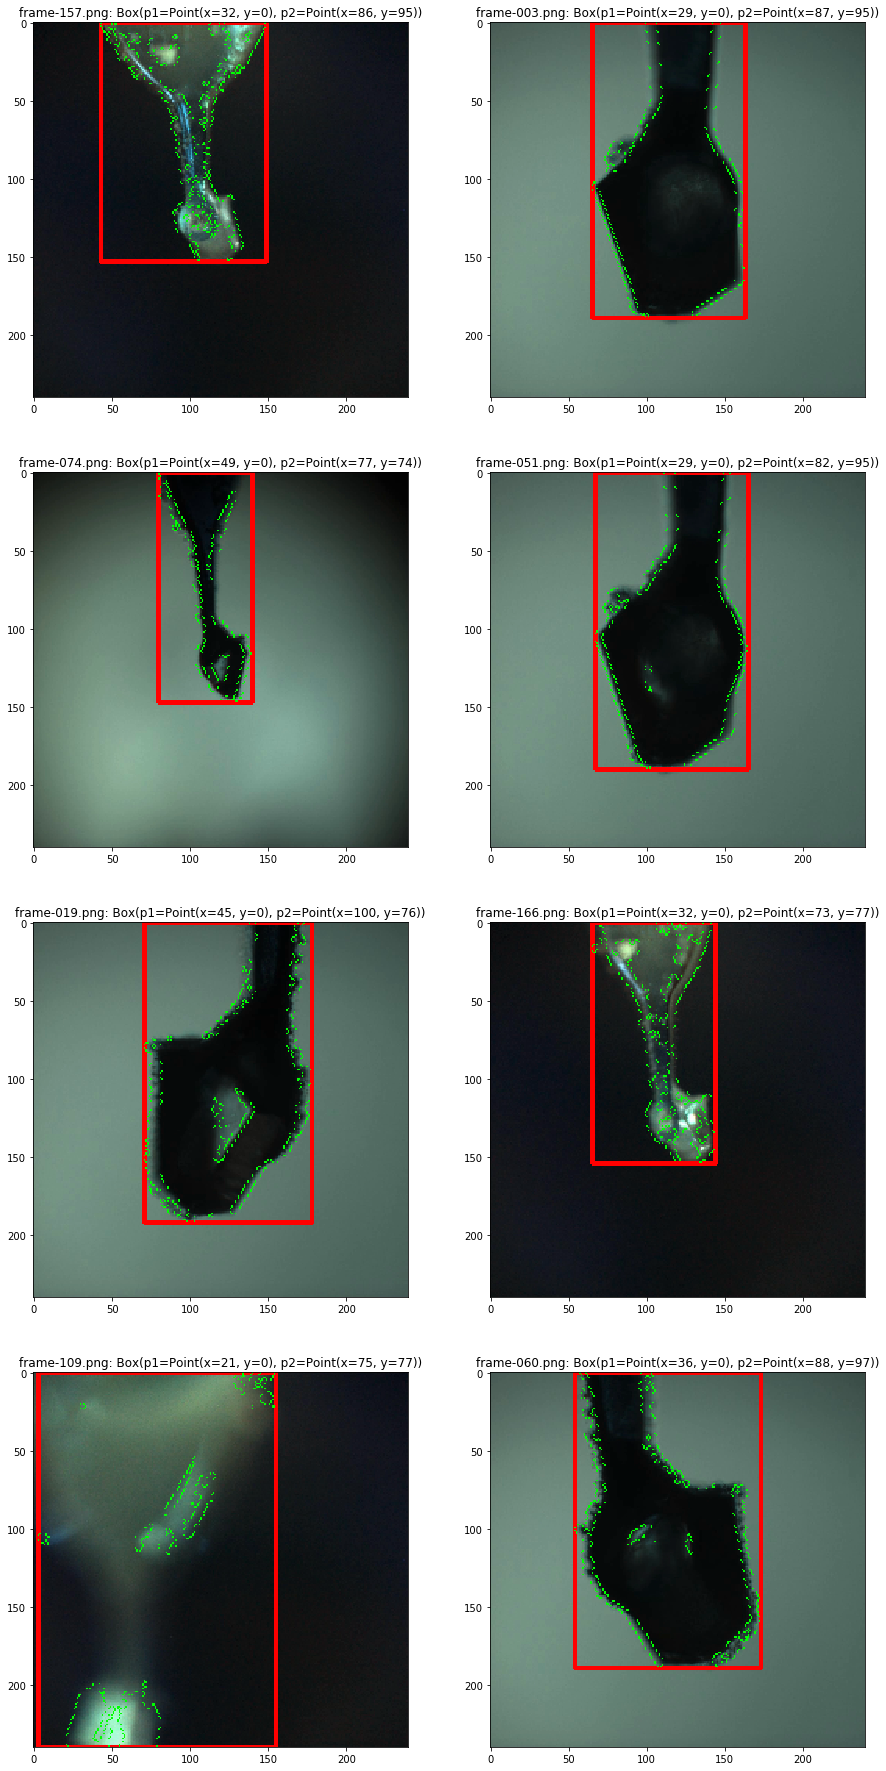

In [429]:
imgs, names = read_sample_images(8)
imgs_sm = map(partial(resize, sz=240), imgs)
box_imgs, boxes = draw_bounding_box_sm(imgs_sm)
titles = [
    f'{os.path.basename(name)}: {str(b2[i])}' for i, name in enumerate(names)
]
plot_images(box_imgs, titles)

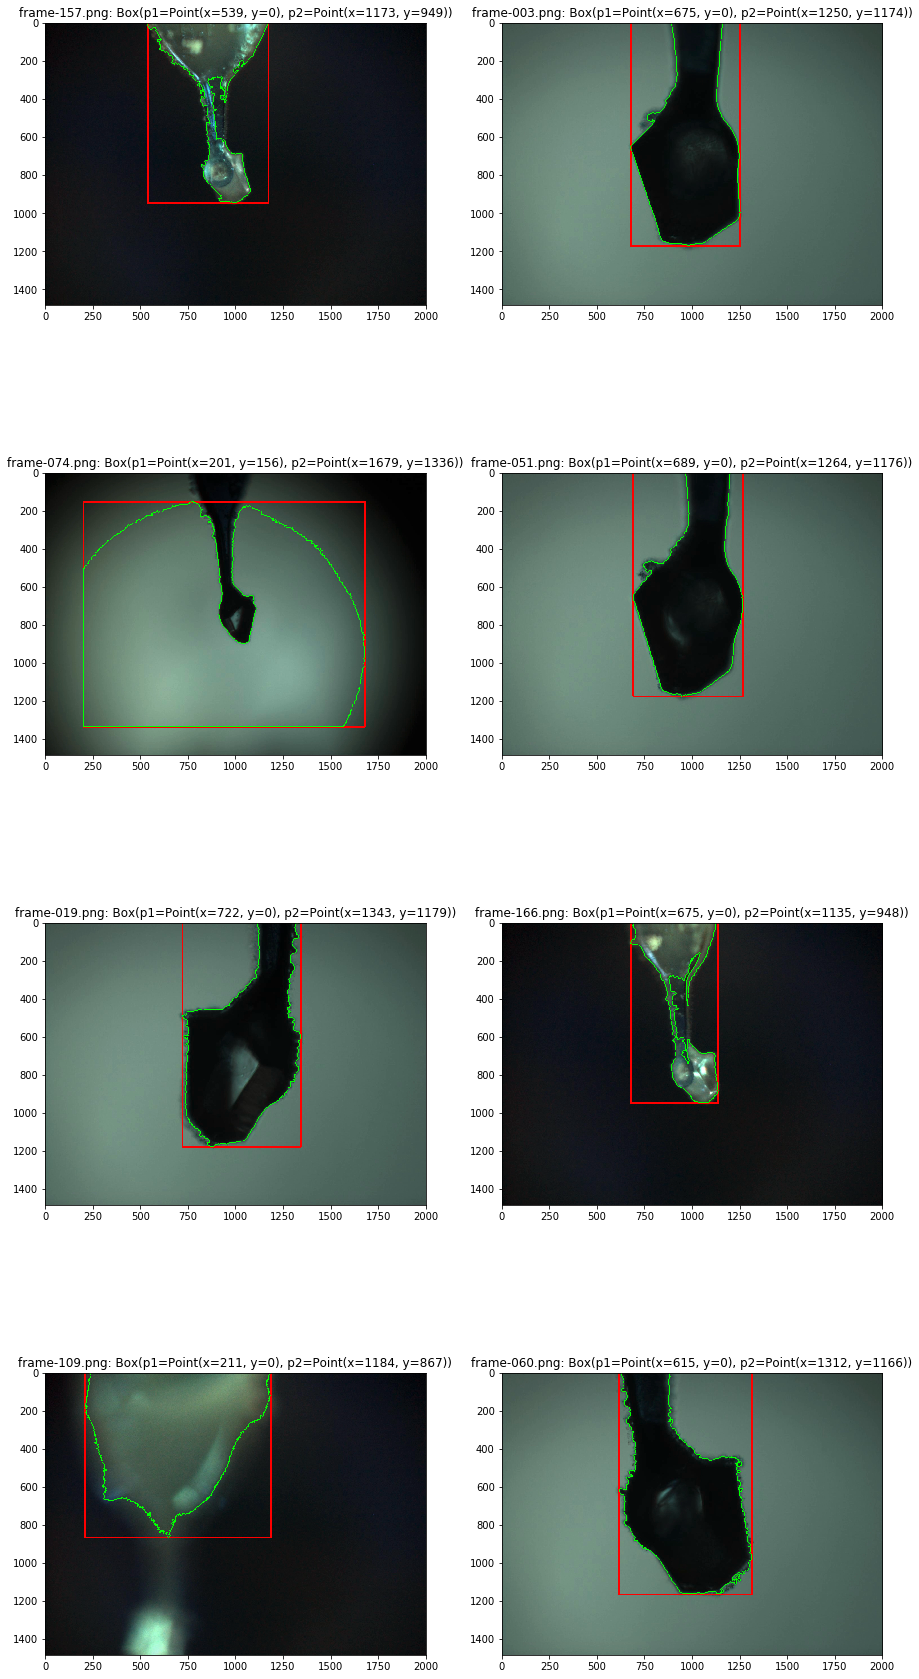

In [430]:
box_imgs, boxes = draw_bounding_box_fs(imgs)
titles = [
    f'{os.path.basename(name)}: {str(boxes[i])}'
    for i, name in enumerate(names)
]
plot_images(box_imgs, titles)